# **Implementacion RFOA**

In [11]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Funciones

In [12]:
class RFOA_ResourceAllocation_Explicit:
    def __init__(self, num_raindrops=50, max_iter=100, budget=10.0):
        self.num_raindrops = num_raindrops
        self.max_iter = max_iter
        self.budget = budget
        self.num_tasks = 5

        # --- CAMBIO PRINCIPAL: Definición explícita de la tabla del PDF ---
        # Guardamos los pares (Recurso, Rendimiento) tal cual aparecen en el enunciado
        self.task_data = [
            {'ref_resource': 1.0, 'ref_yield': 5.0},   # Tarea 1
            {'ref_resource': 2.0, 'ref_yield': 10.0},  # Tarea 2
            {'ref_resource': 3.0, 'ref_yield': 15.0},  # Tarea 3
            {'ref_resource': 4.0, 'ref_yield': 20.0},  # Tarea 4
            {'ref_resource': 5.0, 'ref_yield': 30.0}   # Tarea 5
        ]

        self.raindrops = []
        self.best_solution = None
        self.best_score = -np.inf
        self.history = []

    def calculate_task_performance(self, task_idx, allocated_resource):
        """
        Calcula el rendimiento individual de una tarea usando los datos de referencia.
        Fórmula implícita: (Rendimiento_Ref / Recurso_Ref) * Recurso_Asignado
        """
        data = self.task_data[task_idx]

        # Eficiencia = Cuánto gano por cada unidad de recurso invertida
        efficiency = data['ref_yield'] / data['ref_resource']

        return efficiency * allocated_resource

    def fitness_function(self, solution):
        """
        Suma el rendimiento de todas las tareas calculándolo dinámicamente.
        """
        total_performance = 0
        for i in range(self.num_tasks):
            # Calculamos el aporte de cada tarea i con su asignación solution[i]
            total_performance += self.calculate_task_performance(i, solution[i])

        return total_performance

    def normalize(self, vector):
        """Ajusta el vector para que sume exactamente el presupuesto (10)"""
        vector = np.maximum(vector, 0)
        total = np.sum(vector)
        if total > 0:
            return (vector / total) * self.budget
        else:
            v = np.random.rand(self.num_tasks)
            return (v / np.sum(v)) * self.budget

    def generate_rain(self):
        self.raindrops = []

        # ELIMINAMOS LA "ESTRATEGIA DE BORDES" (El bucle for de los vértices)
        # Ahora todas las gotas son aleatorias desde el principio.

        while len(self.raindrops) < self.num_raindrops:
            drop = np.random.rand(self.num_tasks)
            # Usamos normalize para asegurar que sumen 10, pero la distribución es random
            self.raindrops.append(self.normalize(drop))

        self.raindrops = np.array(self.raindrops)

    def runoff_process(self):
        alpha = 0.2

        for i in range(self.num_raindrops):
            current_drop = self.raindrops[i]

            r = np.random.random()
            movement = alpha * r * (self.best_solution - current_drop)
            noise = np.random.normal(0, 0.5, self.num_tasks)

            new_position = current_drop + movement + noise
            new_position = self.normalize(new_position) # Mantener factibilidad

            current_score = self.fitness_function(current_drop)
            new_score = self.fitness_function(new_position)

            if new_score > current_score:
                self.raindrops[i] = new_position
                if new_score > self.best_score:
                    self.best_score = new_score
                    self.best_solution = new_position.copy()

    def optimize(self):
        print("Resultados RFOA:")
        self.generate_rain()

        # Evaluar inicial
        for drop in self.raindrops:
            score = self.fitness_function(drop)
            if score > self.best_score:
                self.best_score = score
                self.best_solution = drop.copy()

        self.history.append(self.best_score)

        for iteration in range(self.max_iter):
            self.runoff_process()
            self.history.append(self.best_score)

            if iteration % 20 == 0:
                print(f"Iteración {iteration}: Rendimiento = {self.best_score:.2f}")

        return self.best_solution, self.best_score, self.history

## Ejecución del Problema

Resultados RFOA:
Iteración 0: Rendimiento = 56.31
Iteración 20: Rendimiento = 60.00
Iteración 40: Rendimiento = 60.00
Iteración 60: Rendimiento = 60.00
Iteración 80: Rendimiento = 60.00

RESULTADOS FINAL RFOA
Mejor Rendimiento: 60.0000
Asignación de Recursos:
  T1: 0.0000
  T2: 0.0000
  T3: 0.0000
  T4: 0.0000
  T5: 10.0000


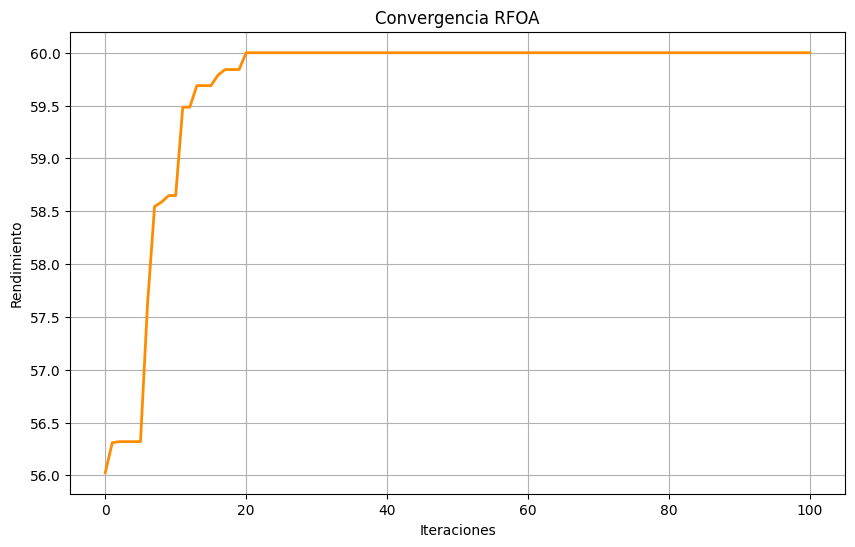

In [13]:
rfoa = RFOA_ResourceAllocation_Explicit(num_raindrops=50, max_iter=100, budget=10.0)
best_sol, best_val, history = rfoa.optimize()

print("\n" + "="*40)
print("RESULTADOS FINAL RFOA")
print("="*40)
print(f"Mejor Rendimiento: {best_val:.4f}")
print("Asignación de Recursos:")
tags = ["T1", "T2", "T3", "T4", "T5"]
for t, r in zip(tags, best_sol):
    print(f"  {t}: {r:.4f}")

# Gráfica
plt.figure(figsize=(10, 6))
plt.plot(history, linewidth=2, color='darkorange')
plt.title('Convergencia RFOA')
plt.xlabel('Iteraciones')
plt.ylabel('Rendimiento')
plt.grid(True)
plt.savefig('rfoa_explicit.png')
plt.show()